In [1]:
# Importing Lib & tools
import os
import cv2
import scipy
import warnings
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt

from keras.optimizers import Adam, RMSprop
from keras.models import Sequential, Model
from keras.layers import  Conv2D, MaxPooling2D, Activation, Flatten,Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Filter Warnings
warnings.filterwarnings("ignore")

In [3]:
# File Dir
input_path = "../input/chest-xray-for-covid19-detection/Dataset/"

In [4]:
# File Contents
for _set in ['Train', 'Val']:
    Normal = len(os.listdir(input_path + _set + '/Normal'))
    Infected = len(os.listdir(input_path + _set + '/Covid'))
    print('The {} folder contains {} Normal and {} Infected images.'.format(_set, Normal, Infected))

The Train folder contains 144 Normal and 144 Infected images.
The Val folder contains 30 Normal and 30 Infected images.


In [53]:
# Preprocesing Data Function
def preprocess_data(input_path, img_dims, batch_size):
    
    # Data Augmentation for Infected & Normal Images
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.5,
        shear_range = 0.6,      
        rotation_range = 30,
        width_shift_range = 0.3,
        height_shift_range = 0.5,
        horizontal_flip = True,
        fill_mode='nearest')

    test_datagen = ImageDataGenerator(
        rescale = 1./255)
    
    train_images = train_datagen.flow_from_directory(
        directory = input_path + 'Train/', 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary')

    test_images = test_datagen.flow_from_directory(
        directory = input_path + 'Val/', 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary')

    # Creating these lists for make prediction on test image and showing confusion matrix.
    train_labels = []
    test_labels = []
           
            
            
    for file_name in ['/Normal/', '/Covid/']:
        for img in (os.listdir(input_path + 'Val' + file_name)):
            img = cv2.imread(input_path + 'Val' + file_name + img, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if file_name == '/Normal/':
                label = 0
            elif file_name == '/Covid/':
                label = 1
            test_labels.append(label)
        
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, test_images, test_labels

In [55]:
img_dims = 180
epochs = 20
batch_size = 2

# Set Images&Labels for Train,Test
train_images, train_labels, test_images, test_labels = preprocess_data(input_path, img_dims, batch_size)
print(train_labels)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
[]


In [46]:
# Create Model with KERAS library
model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=(img_dims,img_dims,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 18, 18, 128)      

In [47]:
# Set Optimizer
optimizer = RMSprop(lr=0.0001)


# Compile Model
model.compile( optimizer= optimizer,loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Fit the Model
#print(train_labels)
history = model.fit(train_images,
       steps_per_epoch = len(train_images) // batch_size, 
        epochs = epochs, 
            validation_data = test_images,
            validation_steps = len(test_images) // batch_size)
#)

Epoch 1/20
72/72 [==============================] - 15s 205ms/step - loss: 0.7018 - accuracy: 0.4931 - val_loss: 0.6869 - val_accuracy: 0.6333
Epoch 2/20
72/72 [==============================] - 13s 181ms/step - loss: 0.6723 - accuracy: 0.5972 - val_loss: 0.7058 - val_accuracy: 0.4333
Epoch 3/20
72/72 [==============================] - 13s 185ms/step - loss: 0.6935 - accuracy: 0.5625 - val_loss: 0.7353 - val_accuracy: 0.4000
Epoch 4/20
72/72 [==============================] - 14s 189ms/step - loss: 0.6683 - accuracy: 0.5764 - val_loss: 0.6408 - val_accuracy: 0.5667
Epoch 5/20
72/72 [==============================] - 14s 192ms/step - loss: 0.6414 - accuracy: 0.6319 - val_loss: 0.5586 - val_accuracy: 0.8333
Epoch 6/20
72/72 [==============================] - 14s 199ms/step - loss: 0.6503 - accuracy: 0.6042 - val_loss: 0.6456 - val_accuracy: 0.5667
Epoch 7/20
72/72 [==============================] - 15s 203ms/step - loss: 0.6297 - accuracy: 0.6528 - val_loss: 0.5800 - val_accuracy: 0.7000

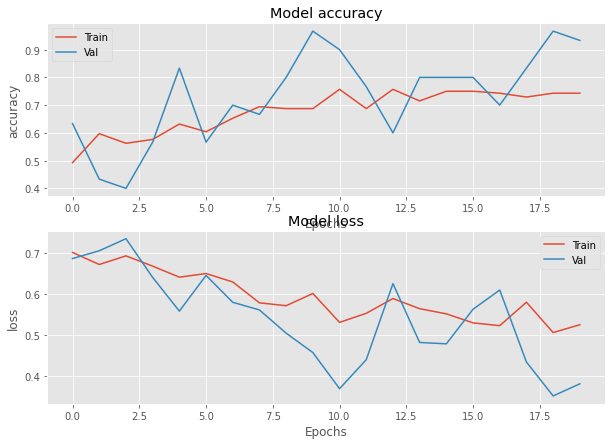

In [51]:
# Visualize Loss and Accuracy Rates
#print(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax = ax.ravel()
plt.style.use("ggplot")

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Val'])

In [64]:
from PIL import Image
from keras.preprocessing import image

# Image Classifer Script
def predict_image(model, img_path, img_dims = 180):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: %', (float)(score*100), 'Infected' if score < 0.5 else 'Normal')


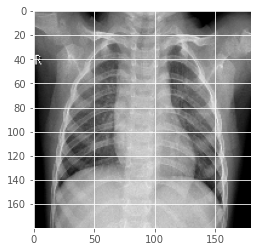

Predictions: % 75.3869857788086 Normal


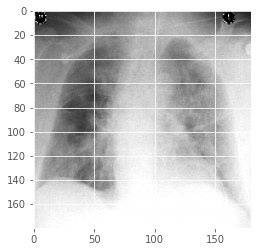

Predictions: % 26.701473236083984 Infected


In [65]:
# Test on Validation Images

predict_image(model,(input_path + 'Prediction/NORMAL2-IM-0352-0001.jpeg'))
predict_image(model,(input_path + 'Prediction/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg'))

In [66]:
# Save Model
model.save("Covid19-CNN-Model.h5")
model.save_weights("Covid19-CNN-weights.h5")